

**Goal: Experiment with a variable lenght SAE. Goal is just overcomplete reconstruction whilst implementing sparseness**

Structure of a Typical SAE

$$
\begin{aligned}
z &= \operatorname{ReLU}(W_{enc}(h - b_{dec}) + b_{enc}) \\
h' &= W_{dec}z + b_{dec}
\end{aligned}
$$

One issue that SAE's suffer from feature splitting which likely is permitted to happen by the fixed size feature size. The experiment in this notebook is to test an architecture of variable feature size SAE.

**Idea: Keepinig W_enc as is we can initialize W_dec as a Weight matrix with k zero columns and on top of sparse activations we can keep additional punishment for having a non 0 column vector for any of those k columns**

# SETUP

In [ ]:
import os
import sys

IN_COLAB = "google.colab" in sys.modules

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

os.environ["OPENAI_API_KEY"] = "YOUR-KEY-HERE!"
os.environ["HUGGINGFACE_KEY"] = "YOUR-KEY-HERE!"

chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"
root = "/content"

if IN_COLAB:
    %pip install einops datasets jaxtyping "sae_lens>=3.23.1" openai tabulate "nbformat>=4.2.0" umap-learn hdbscan eindex-callum git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python git+https://github.com/callummcdougall/sae_vis.git@callum/v3 "transformer-lens>=2.7.0"

if not os.path.exists(f"{root}/{chapter}"):
    !wget https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/arena_pre_v4.zip
    !unzip {root}/arena_pre_v4.zip 'ARENA_3.0-arena_pre_v4/chapter1_transformer_interp/exercises/*'
    !mv {root}/{repo}-arena_pre_v4/{chapter} {root}/{chapter}
    !rm {root}/arena_pre_v4.zip
    !rmdir {root}/{repo}-arena_pre_v4
    sys.path.append(f"{root}/{chapter}/exercises")

  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-2anbfs36
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-2anbfs36
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/callummcdougall/sae_vis.git (to revision callum/v3) to /tmp/pip-req-build-exq2hipk
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/sae_vis.git /tmp/pip-req-build-exq2hipk
  Running command git checkout -b callum/v3 --track origin/callum/v3
  Switched to a new branch 'callum/v3'
  Branch 'callum/v3' set up to track remote branch 'callum/v3' from 'origin'.
  Resolved https://github.com/callummcdougall/sae_vis.git to commit 2e8e0742d481d582a2028cd4910673

In [ ]:
!pip install --upgrade torch torchvision transformers plotly_utils

In [ ]:
import gc
import itertools
import math
import os
import random
import sys
from collections import Counter
from copy import deepcopy
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Any, Callable, Literal, TypeAlias

import einops
import numpy as np
import pandas as pd
import plotly.express as px
import requests
import torch as t
from datasets import load_dataset
from huggingface_hub import hf_hub_download
from IPython.display import HTML, IFrame, clear_output, display
from jaxtyping import Float, Int
from openai import OpenAI
from rich import print as rprint
from rich.table import Table
from sae_lens import (
    SAE,
    ActivationsStore,
    HookedSAETransformer,
    LanguageModelSAERunnerConfig,
    SAEConfig,
    SAETrainingRunner,
    upload_saes_to_huggingface,
)
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
from sae_vis import SaeVisConfig, SaeVisData, SaeVisLayoutConfig
from tabulate import tabulate
from torch import Tensor, nn
from torch.distributions.categorical import Categorical
from torch.nn import functional as F
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.hook_points import HookPoint

device = t.device("mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu")

# Make sure exercises are in the path
chapter = "chapter1_transformer_interp"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = (exercises_dir / "part32_interp_with_saes").resolve()
if str(exercises_dir) not in sys.path:
    sys.path.append(str(exercises_dir))

# import part31_superposition_and_saes.tests as part31_tests
# import part31_superposition_and_saes.utils as part31_utils
# import part32_interp_with_saes.tests as part32_tests
# import part32_interp_with_saes.utils as part32_utils
# from plotly_utils import imshow, line

MAIN = __name__ == "__main__"

In [ ]:
batch_size = 16

# SETUP MODEL ACTIVATIONS DATA

In [ ]:
gpt2: HookedSAETransformer = HookedSAETransformer.from_pretrained("gpt2-small", device=device)
print(gpt2.cfg)

Loaded pretrained model gpt2-small into HookedTransformer
HookedTransformerConfig:
{'NTK_by_parts_factor': 8.0,
 'NTK_by_parts_high_freq_factor': 4.0,
 'NTK_by_parts_low_freq_factor': 1.0,
 'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 8.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 3072,
 'd_model': 768,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': device(type='cuda'),
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.02886751345948129,
 'load_in_4bit': False,
 'model_name': 'gpt2',
 'n_ctx': 1024,
 'n_devices': 1,
 'n_heads': 12,
 'n_key_value_heads': None,
 'n_layers': 12,
 'n_params': 84934656,
 'norm

In [ ]:
test_prompt = "hello"
test_tokens = gpt2.to_tokens(test_prompt)
print("tokens in input", len(test_tokens))


cache = {}
def inspect_hook_shape(act, hook):
    print(f"{hook.name} shape: {act.shape}")
    cache[hook.name] = act
    return act

def cache_hook(act, hook):
    cache[hook.name] = act
    return act


# Running with hooks:
gpt2.run_with_hooks(
    test_prompt,
    fwd_hooks=[
        ("blocks.0.attn.hook_q", inspect_hook_shape),
        ("blocks.0.attn.hook_k", inspect_hook_shape),
        ("blocks.0.attn.hook_v", inspect_hook_shape),
        ("blocks.0.attn.hook_attn_scores", inspect_hook_shape),
        ("blocks.7.hook_resid_pre", inspect_hook_shape)
    ]
)

tokens in input 1
blocks.0.attn.hook_q shape: torch.Size([1, 2, 12, 64])
blocks.0.attn.hook_k shape: torch.Size([1, 2, 12, 64])
blocks.0.attn.hook_v shape: torch.Size([1, 2, 12, 64])
blocks.0.attn.hook_attn_scores shape: torch.Size([1, 12, 2, 2])
blocks.7.hook_resid_pre shape: torch.Size([1, 2, 768])


tensor([[[ 7.5261, 11.1214,  7.8919,  ..., -3.1299, -3.3873,  8.5934],
         [12.4429,  7.8121,  3.6721,  ..., -0.9013,  1.8067,  8.4964]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
dataset = load_dataset("uonlp/CulturaX", "en", streaming=True, split="train")
print(dataset.column_names)
shuffled_dataset_iter = iter(dataset.shuffle(buffer_size=10_000))

def get_next_batch(shuffled_iter, batch_size, max_length = 128):
    batch = []
    while len(batch) < batch_size:
        sample = next(shuffled_iter)
        batch.append(sample['text'][:max_length])
    return batch

Resolving data files:   0%|          | 0/3072 [00:00<?, ?it/s]

['text', 'timestamp', 'url', 'source']


# Define SAE

In [ ]:
def linear_lr(step, steps):
    return 1 - (step / steps)


def constant_lr(*_):
    return 1.0


def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class ToySAEConfig:
    n_inst: int
    d_in: int
    d_sae: int
    hook_name: str
    l1_coeff: float = 0.2
    weight_normalize_eps: float = 1e-8
    tied_weights: bool = False
    architecture: Literal["standard", "gated"] = "standard"



class ToySAE(nn.Module):
    W_enc: Float[Tensor, "inst d_in d_sae"]
    _W_dec: Float[Tensor, "inst d_sae d_in"] | None
    b_enc: Float[Tensor, "inst d_sae"]
    b_dec: Float[Tensor, "inst d_in"]

    def __init__(self: "ToySAE", cfg: Any, model: HookedSAETransformer, shuffled_ds : Any) -> None:
        super(ToySAE, self).__init__()

        assert cfg.d_in == model.cfg.d_hidden, "Model's hidden dim doesn't match SAE input dim"
        self.cfg = cfg
        self.model = model.requires_grad_(False)
        self.shuffled_ds = shuffled_ds

        self.W_enc = nn.Parameter(nn.init.kaiming_uniform_(t.empty((cfg.n_inst, cfg.d_in, cfg.d_sae))))
        self._W_dec = (
            None
            if self.cfg.tied_weights
            else nn.Parameter(nn.init.kaiming_uniform_(t.empty((cfg.n_inst, cfg.d_sae, cfg.d_in))))
        )
        self.b_enc = nn.Parameter(t.zeros(cfg.n_inst, cfg.d_sae))
        self.b_dec = nn.Parameter(t.zeros(cfg.n_inst, cfg.d_in))

        self.to(device)

    @property
    def W_dec(self) -> Float[Tensor, "inst d_sae d_in"]:
        return self._W_dec if self._W_dec is not None else self.W_enc.transpose(-1, -2)

    @property
    def W_dec_normalized(self: "ToySAE") -> Float[Tensor, "inst d_sae d_in"]:
        """Returns decoder weights, normalized over the autoencoder input dimension."""
        return self.W_dec / (self.W_dec.norm(dim=-1, keepdim=True) + self.cfg.weight_normalize_eps)


    def generate_batch(self, batch_size: int) -> Float[Tensor, "batch inst d_in"]:
        """
        Generates a batch of hidden activations from our model.
        """
        batch = get_next_batch(self.shuffled_ds, batch_size)
        gpt2.run_with_hooks(
          batch,
          fwd_hooks=[
              (self.cfg.hook_name, cache_hook),
          ],
          stop_at_layer=self.cfg.hook_layer + 1
        )

        #print(cache[self.cfg.hook_name].shape, self.cfg.n_inst, self.cfg.d_in)

        return cache[self.cfg.hook_name]
        # return einops.einsum(
        #     cache[self.cfg.hook_name],
        #     self.model.W,
        #     "batch inst feats, inst d_in feats -> batch inst d_in",
        # )

    def forward(
        self,
        h: Float[Tensor, "batch inst d_in"],
    ) -> tuple[
        dict[str, Float[Tensor, "batch inst"]],
        Float[Tensor, ""],
        Float[Tensor, "batch inst d_sae"],
        Float[Tensor, "batch inst d_in"],
    ]:
        """
        Forward pass on the autoencoder.

        Args:
            h: hidden layer activations of model

        Returns:
            loss_dict: dict of different loss function term values, for every (batch elem, instance)
            loss: scalar total loss (summed over instances & averaged over batch dim)
            acts: autoencoder feature activations
            h_reconstructed: reconstructed autoencoder input
        """
        h_cent = h - self.b_dec

        acts = einops.einsum(h_cent, self.W_enc, "batch inst d_in, inst d_in d_sae -> batch inst d_sae")
        acts = F.relu(acts + self.b_enc)

        # Compute reconstructed input
        h_reconstructed = (
            einops.einsum(acts, self.W_dec, "batch inst d_sae, inst d_sae d_in -> batch inst d_in") + self.b_dec
        )

        # Compute loss terms
        L_reconstruction = (h_reconstructed - h).pow(2).mean(-1)
        L_sparsity = acts.abs().sum(-1)
        loss_dict = {
            "L_reconstruction": L_reconstruction,
            "L_sparsity": L_sparsity,
        }
        loss = (L_reconstruction + self.cfg.l1_coeff * L_sparsity).mean(0).sum()

        return loss_dict, loss, acts, h_reconstructed

    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 50,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
        resample_method: Literal["simple", "advanced", None] = None,
        resample_freq: int = 2500,
        resample_window: int = 500,
        resample_scale: float = 0.5,
    ) -> dict[str, list]:
        """
        Optimizes the autoencoder using the given hyperparameters.

        Args:
            model:              we reconstruct features from model's hidden activations
            batch_size:         size of batches we pass through model & train autoencoder on
            steps:              number of optimization steps
            log_freq:           number of optimization steps between logging
            lr:                 learning rate
            lr_scale:           learning rate scaling function
            resample_method:    method for resampling dead latents
            resample_freq:      number of optimization steps between resampling dead latents
            resample_window:    number of steps needed for us to classify a neuron as dead
            resample_scale:     scale factor for resampled neurons

        Returns:
            data_log:           dictionary containing data we'll use for visualization
        """
        assert resample_window <= resample_freq

        optimizer = t.optim.Adam(list(self.parameters()), lr=lr, betas=(0.0, 0.999))
        frac_active_list = []
        progress_bar = tqdm(range(steps))

        # Create lists to store data we'll eventually be plotting
        data_log = {"steps": [], "W_enc": [], "W_dec": [], "frac_active": []}

        for step in progress_bar:
            # Resample dead latents
            if (resample_method is not None) and ((step + 1) % resample_freq == 0):
                frac_active_in_window = t.stack(frac_active_list[-resample_window:], dim=0)
                if resample_method == "simple":
                    self.resample_simple(frac_active_in_window, resample_scale)
                elif resample_method == "advanced":
                    self.resample_advanced(frac_active_in_window, resample_scale, batch_size)

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group["lr"] = step_lr

            # Get a batch of hidden activations from the model
            with t.inference_mode():
                h = self.generate_batch(batch_size)

            # Optimize
            loss_dict, loss, acts, _ = self.forward(h)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Normalize decoder weights by modifying them inplace (if not using tied weights)
            if not self.cfg.tied_weights:
                self.W_dec.data = self.W_dec_normalized

            # Calculate the mean sparsities over batch dim for each feature
            frac_active = (acts.abs() > 1e-8).float().mean(0)
            frac_active_list.append(frac_active)

            # Display progress bar, and append new values for plotting
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(
                    lr=step_lr,
                    frac_active=frac_active.mean().item(),
                    **{k: v.mean(0).sum().item() for k, v in loss_dict.items()},  # type: ignore
                )
                data_log["W_enc"].append(self.W_enc.detach().cpu().clone())
                data_log["W_dec"].append(self.W_dec.detach().cpu().clone())
                data_log["frac_active"].append(frac_active.detach().cpu().clone())
                data_log["steps"].append(step)

        return data_log

    @t.no_grad()
    def resample_simple(
        self: "ToySAE",
        frac_active_in_window: Float[Tensor, "window inst d_sae"],
        resample_scale: float,
    ) -> None:
        """
        Resamples dead latents, by modifying the model's weights and biases inplace.

        Resampling method is:
            - For each dead neuron, generate a random vector of size (d_in,), and normalize these vectors
            - Set new values of W_dec and W_enc to be these normalized vectors, at each dead neuron
            - Set b_enc to be zero, at each dead neuron

        This function performs resampling over all instances at once, using batched operations.
        """
        # Get a tensor of dead latents
        dead_latents_mask = (frac_active_in_window < 1e-8).all(dim=0)  # [instances d_sae]
        n_dead = int(dead_latents_mask.int().sum().item())

        # Get our random replacement values of shape [n_dead d_in], and scale them
        replacement_values = t.randn((n_dead, self.cfg.d_in), device=self.W_enc.device)
        replacement_values_normed = replacement_values / (
            replacement_values.norm(dim=-1, keepdim=True) + self.cfg.weight_normalize_eps
        )

        # Change the corresponding values in W_enc, W_dec, and b_enc
        self.W_enc.data.transpose(-1, -2)[dead_latents_mask] = resample_scale * replacement_values_normed
        self.W_dec.data[dead_latents_mask] = replacement_values_normed
        self.b_enc.data[dead_latents_mask] = 0.0



In [ ]:
##We'll just get the same CFG as the HF one

hook_name = "blocks.7.hook_resid_pre"

gpt2_sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gpt2-small-res-jb",
    sae_id=hook_name,
    device=str(device),
)
print(gpt2_sae.cfg.hook_layer)


cfg = gpt2_sae.cfg
cfg.n_inst = 1
cfg.tied_weights = False
cfg.l1_coeff = 0.2
cfg.weight_normalize_eps = 1e-8
cfg.architecture="standard"
gpt2.cfg.d_hidden = gpt2_sae.cfg.d_in



model = gpt2

sae = ToySAE(cfg=cfg, model=model, shuffled_ds = shuffled_dataset_iter)

h = sae.generate_batch(16)

7


  0%|          | 0/1500 [00:00<?, ?it/s]

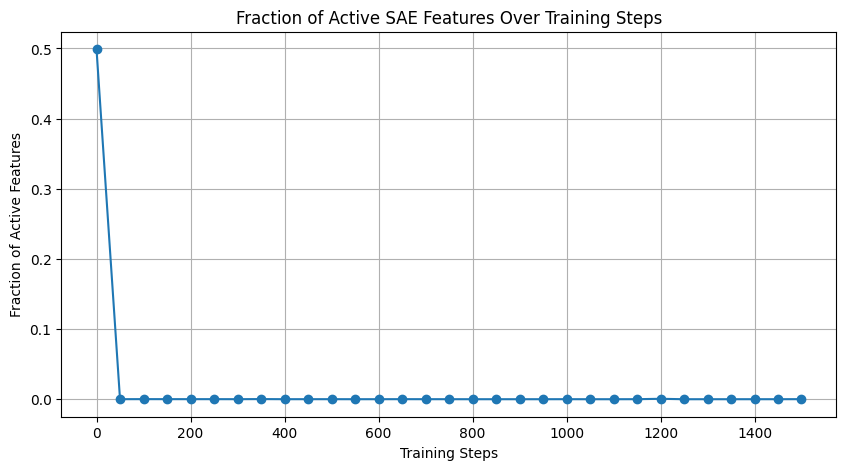

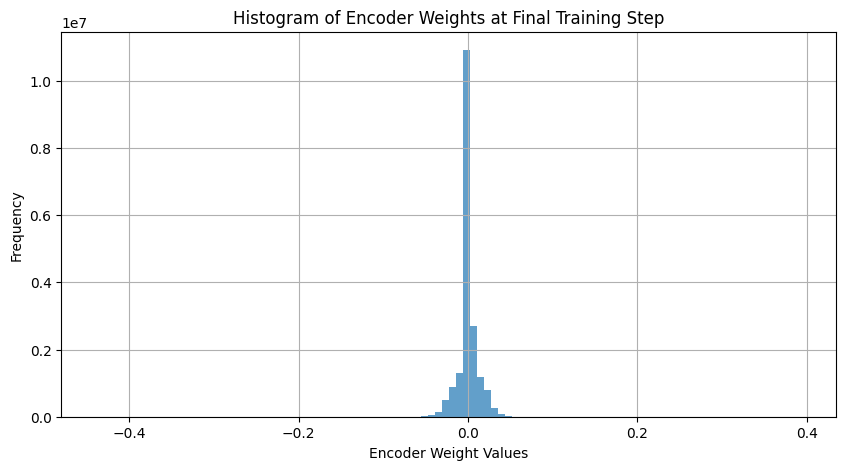

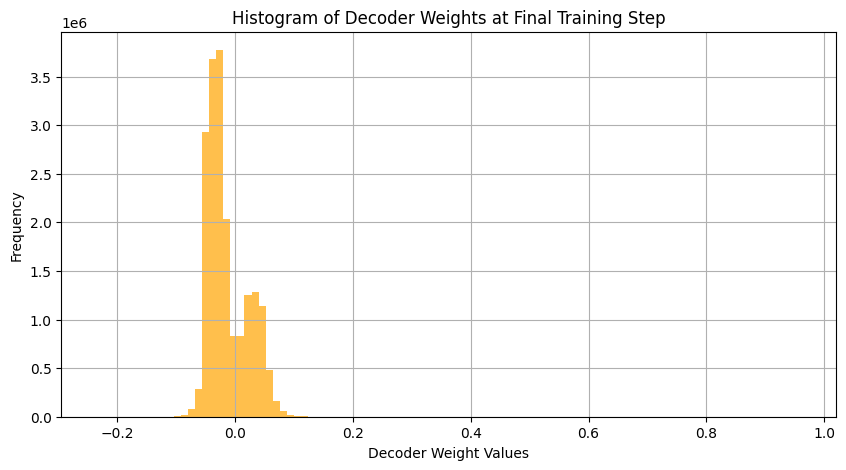

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t

# Extract data
data_log = sae.optimize(batch_size = 16, steps = 1500)
steps = data_log["steps"]
frac_active = [fa.mean().item() for fa in data_log["frac_active"]]

# Plot fraction of active features
plt.figure(figsize=(10, 5))
plt.plot(steps, frac_active, marker='o')
plt.xlabel('Training Steps')
plt.ylabel('Fraction of Active Features')
plt.title('Fraction of Active SAE Features Over Training Steps')
plt.grid(True)
plt.show()

# Plot histogram of encoder weights at final step
final_W_enc = data_log["W_enc"][-1].cpu().numpy().flatten()
plt.figure(figsize=(10, 5))
plt.hist(final_W_enc, bins=100, alpha=0.7)
plt.xlabel('Encoder Weight Values')
plt.ylabel('Frequency')
plt.title('Histogram of Encoder Weights at Final Training Step')
plt.grid(True)
plt.show()

# Plot histogram of decoder weights at final step
final_W_dec = data_log["W_dec"][-1].cpu().numpy().flatten()
plt.figure(figsize=(10, 5))
plt.hist(final_W_dec, bins=100, alpha=0.7, color='orange')
plt.xlabel('Decoder Weight Values')
plt.ylabel('Frequency')
plt.title('Histogram of Decoder Weights at Final Training Step')
plt.grid(True)
plt.show()


# Variable SAE

In [ ]:
def linear_lr(step, steps):
    return 1 - (step / steps)


def constant_lr(*_):
    return 1.0


def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))


@dataclass
class VarSAEConfig:
    n_inst: int
    d_in: int
    d_sae: int
    hook_name: str
    l1_coeff: float = 0.2
    weight_normalize_eps: float = 1e-8
    tied_weights: bool = False
    architecture: Literal["standard", "gated"] = "standard"
    inactive_columns: int = 0         # New: number of latent columns to be inactive initially
    col_sparsity_coeff: float = 0.1



class VarSAE(nn.Module):
    W_enc: Float[Tensor, "inst d_in d_sae"]
    _W_dec: Float[Tensor, "inst d_sae d_in"] | None
    b_enc: Float[Tensor, "inst d_sae"]
    b_dec: Float[Tensor, "inst d_in"]

    def __init__(self: "VarSAE", cfg: Any, model: HookedSAETransformer, shuffled_ds: Any) -> None:
        super(VarSAE, self).__init__()

        assert cfg.d_in == model.cfg.d_hidden, "Model's hidden dim doesn't match SAE input dim"
        self.cfg = cfg
        self.model = model.requires_grad_(False)
        self.shuffled_ds = shuffled_ds

        self.W_enc = nn.Parameter(nn.init.kaiming_uniform_(t.empty((cfg.n_inst, cfg.d_in, cfg.d_sae))))
        self._W_dec = (
            None
            if self.cfg.tied_weights
            else nn.Parameter(nn.init.kaiming_uniform_(t.empty((cfg.n_inst, cfg.d_sae, cfg.d_in))))
        )
        self.b_enc = nn.Parameter(t.zeros(cfg.n_inst, cfg.d_sae))
        self.b_dec = nn.Parameter(t.zeros(cfg.n_inst, cfg.d_in))

        # If we want some latent columns inactive, set the last inactive_columns of W_enc to 0.
        if self.cfg.inactive_columns > 0:
            self.W_enc.data[..., -self.cfg.inactive_columns:] = 0.0
            # For untied weights, also zero-out the corresponding rows in decoder weights
            if not self.cfg.tied_weights:
                self._W_dec.data[:, -self.cfg.inactive_columns:, :] = 0.0

        self.to(device)

    @property
    def W_dec(self) -> Float[Tensor, "inst d_sae d_in"]:
        return self._W_dec if self._W_dec is not None else self.W_enc.transpose(-1, -2)

    @property
    def W_dec_normalized(self: "VarSAE") -> Float[Tensor, "inst d_sae d_in"]:
        """Returns decoder weights, normalized over the autoencoder input dimension."""
        return self.W_dec / (self.W_dec.norm(dim=-1, keepdim=True) + self.cfg.weight_normalize_eps)

    def generate_batch(self, batch_size: int) -> Float[Tensor, "batch inst d_in"]:
        batch = get_next_batch(self.shuffled_ds, batch_size)
        gpt2.run_with_hooks(
            batch,
            fwd_hooks=[(self.cfg.hook_name, cache_hook)],
            stop_at_layer=self.cfg.hook_layer + 1
        )
        return cache[self.cfg.hook_name]

        #print(cache[self.cfg.hook_name].shape, self.cfg.n_inst, self.cfg.d_in)

        return cache[self.cfg.hook_name]
        # return einops.einsum(
        #     cache[self.cfg.hook_name],
        #     self.model.W,
        #     "batch inst feats, inst d_in feats -> batch inst d_in",
        # )

    def compute_column_penalty(self) -> Float[Tensor, ""]:
        """
        Computes an extra penalty term that enforces sparsity on the last k columns
        of the decoder (using normalized weights). This term is:
            || W_dec_normalized * penalty_vector ||_1
        where penalty_vector has zeros for the first (d_sae - inactive_columns) entries and
        col_sparsity_coeff for the last inactive_columns entries.
        """
        if self.cfg.inactive_columns > 0:
            # Create penalty vector of shape (d_sae,)
            penalty_vector = t.zeros(self.cfg.d_sae, device=self.W_dec.device)
            penalty_vector[-self.cfg.inactive_columns:] = self.cfg.col_sparsity_coeff
            # Reshape for broadcasting: (1, d_sae, 1)
            penalty_vector = penalty_vector.view(1, -1, 1)
            # Compute L1 penalty on normalized decoder weights weighted by the penalty vector
            L_column = (t.abs(self.W_dec_normalized) * penalty_vector).sum()
            return L_column
        else:
            return 0.0

    def forward(
        self,
        h: Float[Tensor, "batch inst d_in"],
    ) -> tuple[
        dict[str, Float[Tensor, "batch inst"]],
        Float[Tensor, ""],
        Float[Tensor, "batch inst d_sae"],
        Float[Tensor, "batch inst d_in"],
    ]:
        """
        Forward pass on the autoencoder.
        """
        h_cent = h - self.b_dec
        acts = einops.einsum(h_cent, self.W_enc, "batch inst d_in, inst d_in d_sae -> batch inst d_sae")
        acts = F.relu(acts + self.b_enc)

        # Reconstruct the input
        h_reconstructed = (
            einops.einsum(acts, self.W_dec, "batch inst d_sae, inst d_sae d_in -> batch inst d_in") + self.b_dec
        )

        # Reconstruction loss and L1 sparsity on activations
        L_reconstruction = (h_reconstructed - h).pow(2).mean(-1)
        L_sparsity = acts.abs().sum(-1)

        # Compute extra penalty for the last inactive columns
        L_column = self.compute_column_penalty()

        # Total loss: average over batch and sum over instances, plus the column penalty
        loss = (L_reconstruction + self.cfg.l1_coeff * L_sparsity).mean(0).sum() + L_column

        loss_dict = {
            "L_reconstruction": L_reconstruction,
            "L_sparsity": L_sparsity,
            "L_column": L_column,
        }
        return loss_dict, loss, acts, h_reconstructed

    def optimize(
        self,
        batch_size: int = 1024,
        steps: int = 10_000,
        log_freq: int = 50,
        lr: float = 1e-3,
        lr_scale: Callable[[int, int], float] = constant_lr,
        resample_method: Literal["simple", "advanced", None] = None,
        resample_freq: int = 2500,
        resample_window: int = 500,
        resample_scale: float = 0.5,
    ) -> dict[str, list]:
        """
        Optimizes the autoencoder using the given hyperparameters.

        Args:
            model:              we reconstruct features from model's hidden activations
            batch_size:         size of batches we pass through model & train autoencoder on
            steps:              number of optimization steps
            log_freq:           number of optimization steps between logging
            lr:                 learning rate
            lr_scale:           learning rate scaling function
            resample_method:    method for resampling dead latents
            resample_freq:      number of optimization steps between resampling dead latents
            resample_window:    number of steps needed for us to classify a neuron as dead
            resample_scale:     scale factor for resampled neurons

        Returns:
            data_log:           dictionary containing data we'll use for visualization
        """
        assert resample_window <= resample_freq

        optimizer = t.optim.Adam(list(self.parameters()), lr=lr, betas=(0.0, 0.999))
        frac_active_list = []
        progress_bar = tqdm(range(steps))

        # Create lists to store data we'll eventually be plotting
        data_log = {"steps": [], "W_enc": [], "W_dec": [], "frac_active": []}

        for step in progress_bar:
            # Resample dead latents
            if (resample_method is not None) and ((step + 1) % resample_freq == 0):
                frac_active_in_window = t.stack(frac_active_list[-resample_window:], dim=0)
                if resample_method == "simple":
                    self.resample_simple(frac_active_in_window, resample_scale)
                elif resample_method == "advanced":
                    self.resample_advanced(frac_active_in_window, resample_scale, batch_size)

            # Update learning rate
            step_lr = lr * lr_scale(step, steps)
            for group in optimizer.param_groups:
                group["lr"] = step_lr

            # Get a batch of hidden activations from the model
            with t.inference_mode():
                h = self.generate_batch(batch_size)

            # Optimize
            loss_dict, loss, acts, _ = self.forward(h)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Normalize decoder weights by modifying them inplace (if not using tied weights)
            if not self.cfg.tied_weights:
                self.W_dec.data = self.W_dec_normalized

            # Calculate the mean sparsities over batch dim for each feature
            frac_active = (acts.abs() > 1e-8).float().mean(0)
            frac_active_list.append(frac_active)

            # Display progress bar, and append new values for plotting
            if step % log_freq == 0 or (step + 1 == steps):
                progress_bar.set_postfix(
                    lr=step_lr,
                    frac_active=frac_active.mean().item(),
                    **{k: v.mean(0).sum().item() for k, v in loss_dict.items()},  # type: ignore
                )
                data_log["W_enc"].append(self.W_enc.detach().cpu().clone())
                data_log["W_dec"].append(self.W_dec.detach().cpu().clone())
                data_log["frac_active"].append(frac_active.detach().cpu().clone())
                data_log["steps"].append(step)

        return data_log

    @t.no_grad()
    def resample_simple(
        self: "ToySAE",
        frac_active_in_window: Float[Tensor, "window inst d_sae"],
        resample_scale: float,
    ) -> None:
        """
        Resamples dead latents, by modifying the model's weights and biases inplace.

        Resampling method is:
            - For each dead neuron, generate a random vector of size (d_in,), and normalize these vectors
            - Set new values of W_dec and W_enc to be these normalized vectors, at each dead neuron
            - Set b_enc to be zero, at each dead neuron

        This function performs resampling over all instances at once, using batched operations.
        """
        # Get a tensor of dead latents
        dead_latents_mask = (frac_active_in_window < 1e-8).all(dim=0)  # [instances d_sae]
        n_dead = int(dead_latents_mask.int().sum().item())

        # Get our random replacement values of shape [n_dead d_in], and scale them
        replacement_values = t.randn((n_dead, self.cfg.d_in), device=self.W_enc.device)
        replacement_values_normed = replacement_values / (
            replacement_values.norm(dim=-1, keepdim=True) + self.cfg.weight_normalize_eps
        )

        # Change the corresponding values in W_enc, W_dec, and b_enc
        self.W_enc.data.transpose(-1, -2)[dead_latents_mask] = resample_scale * replacement_values_normed
        self.W_dec.data[dead_latents_mask] = replacement_values_normed
        self.b_enc.data[dead_latents_mask] = 0.0



In [ ]:
##We'll just get the same CFG as the HF one

hook_name = "blocks.7.hook_resid_pre"

gpt2_sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gpt2-small-res-jb",
    sae_id=hook_name,
    device=str(device),
)
print(gpt2_sae.cfg.hook_layer)


cfg = gpt2_sae.cfg
cfg.n_inst = 1
cfg.tied_weights = False
cfg.l1_coeff = 0.2
cfg.weight_normalize_eps = 1e-8
cfg.architecture="standard"
gpt2.cfg.d_hidden = gpt2_sae.cfg.d_in



model = gpt2

sae = VarSAE(cfg=cfg, model=model, shuffled_ds = shuffled_dataset_iter)

h = sae.generate_batch(16)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t

# Extract data
data_log = sae.optimize(batch_size = 16, steps = 1500)
steps = data_log["steps"]
frac_active = [fa.mean().item() for fa in data_log["frac_active"]]

# Plot fraction of active features
plt.figure(figsize=(10, 5))
plt.plot(steps, frac_active, marker='o')
plt.xlabel('Training Steps')
plt.ylabel('Fraction of Active Features')
plt.title('Fraction of Active SAE Features Over Training Steps')
plt.grid(True)
plt.show()

# Plot histogram of encoder weights at final step
final_W_enc = data_log["W_enc"][-1].cpu().numpy().flatten()
plt.figure(figsize=(10, 5))
plt.hist(final_W_enc, bins=100, alpha=0.7)
plt.xlabel('Encoder Weight Values')
plt.ylabel('Frequency')
plt.title('Histogram of Encoder Weights at Final Training Step')
plt.grid(True)
plt.show()

# Plot histogram of decoder weights at final step
final_W_dec = data_log["W_dec"][-1].cpu().numpy().flatten()
plt.figure(figsize=(10, 5))
plt.hist(final_W_dec, bins=100, alpha=0.7, color='orange')
plt.xlabel('Decoder Weight Values')
plt.ylabel('Frequency')
plt.title('Histogram of Decoder Weights at Final Training Step')
plt.grid(True)
plt.show()
